In [2]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
headers = {
    'Accept': '*/*',
    'Accept-Language': 'en-US,en;q=0.9',
    'Connection': 'keep-alive',
    'Origin': 'https://www.wnba.com',
    'Referer': 'https://www.wnba.com/',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
    'Host': 'stats.wnba.com',
    'x-wnba-stats-origin': 'stats',
    'x-wnba-stats-token': 'true'
}

def json_extract():
    years = ['2024', '2023', '2022','2021','2020','2019','2018']
    # Went to 2018 because that's when ORTG boost and pace increased
    all_data = []  # List to store data from all years

    for year in years:
        url = F'https://stats.wnba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=10&Location=&MeasureType=Four+Factors&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={year}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='

        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                data = response.json()
                print(f"Successfully got data for {year}!")
                
                # Create DataFrame for current year
                df_year = pd.DataFrame(data['resultSets'][0]['rowSet'], 
                columns=data['resultSets'][0]['headers'])
                
                # Add year column
                df_year['Season'] = year
                
                # Append to list of DataFrames
                all_data.append(df_year)
            else:
                print(f"Failed to get data for {year}: Status code {response.status_code}")
                
        except Exception as e:
            print(f"Error occurred for {year}: {e}")

    # Combine all DataFrames
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

# Execute function and store result
combined_df = json_extract()
combined_df.head()

Successfully got data for 2024!
Successfully got data for 2023!
Successfully got data for 2022!
Successfully got data for 2021!
Successfully got data for 2020!
Successfully got data for 2019!
Successfully got data for 2018!


,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,MIN_RANK,EFG_PCT_RANK,FTA_RATE_RANK,TM_TOV_PCT_RANK,OREB_PCT_RANK,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,Season
0,1611661330,Atlanta Dream,40,15,25,0.375,1615.0,0.452,0.294,0.173,...,1,12,3,4,4,5,5,6,3,2024
1,1611661329,Chicago Sky,40,13,27,0.325,1600.0,0.457,0.252,0.179,...,11,11,7,8,2,8,11,7,7,2024
2,1611661323,Connecticut Sun,40,28,12,0.700,1610.0,0.488,0.317,0.170,...,4,8,1,3,3,4,6,1,4,2024
3,1611661321,Dallas Wings,40,9,31,0.225,1615.0,0.490,0.263,0.190,...,1,7,6,10,1,12,10,9,10,2024
4,1611661325,Indiana Fever,40,20,20,0.500,1605.0,0.523,0.250,0.188,...,8,1,10,9,7,10,9,12,6,2024


In [4]:
#We need to tranform the data to get the differences between our selected values
def calc_dev():
    combined_df['Shooting Dev'] = combined_df['EFG_PCT']-combined_df['OPP_EFG_PCT']
    combined_df['Rebounding Dev'] = combined_df['OREB_PCT']-combined_df['OPP_OREB_PCT']
    combined_df['Turnover Dev'] = combined_df['TM_TOV_PCT']-combined_df['OPP_TOV_PCT']
    combined_df['Free Throw Dev'] = combined_df['FTA_RATE']-combined_df['OPP_FTA_RATE']
    return combined_df
calc_dev()
combined_df.head(5)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,OREB_PCT_RANK,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,Season,Shooting Dev,Rebounding Dev,Turnover Dev,Free Throw Dev
0,1611661330,Atlanta Dream,40,15,25,0.375,1615.0,0.452,0.294,0.173,...,4,5,5,6,3,2024,-0.036,0.039,0.003,0.033
1,1611661329,Chicago Sky,40,13,27,0.325,1600.0,0.457,0.252,0.179,...,2,8,11,7,7,2024,-0.042,0.054,0.010,-0.043
2,1611661323,Connecticut Sun,40,28,12,0.700,1610.0,0.488,0.317,0.170,...,3,4,6,1,4,2024,0.006,0.035,-0.039,0.055
3,1611661321,Dallas Wings,40,9,31,0.225,1615.0,0.490,0.263,0.190,...,1,12,10,9,10,2024,-0.046,0.031,0.024,-0.030
4,1611661325,Indiana Fever,40,20,20,0.500,1605.0,0.523,0.250,0.188,...,7,10,9,12,6,2024,0.016,0.006,0.039,-0.034


In [5]:
#Choosing the features we want to use
features= ['Shooting Dev','Rebounding Dev','Turnover Dev', 'Free Throw Dev']

# Filtering out 2024 season
X = combined_df[features]
# Choosing the target variable
y = combined_df['W_PCT']




In [6]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [7]:
# Linear
lr = LinearRegression().fit(X_train, y_train)

# Ridge
ridge = Ridge(alpha=1.0).fit(X_train, y_train)

# Lasso
lasso = Lasso(alpha=0.1).fit(X_train, y_train)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)


In [8]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return {"Model": name, "R2": r2, "RMSE": rmse}


results = [
    evaluate_model("Linear Regression", lr),
    evaluate_model("Ridge", ridge),
    evaluate_model("Lasso", lasso),
    evaluate_model("Random Forest", rf)
]

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print(results_df)


               Model        R2      RMSE
0  Linear Regression  0.943522  0.036883
3      Random Forest  0.894923  0.050308
1              Ridge  0.165332  0.141787
2              Lasso -0.000083  0.155203


In [9]:
# Function to evaluate the full model with cross-validation
def full_model_eval(model, name, X_train, X_test, y_train, y_test, X_full, y_full, cv=5):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Holdout test set
    r2_holdout = r2_score(y_test, y_pred)
    rmse_holdout = np.sqrt(mean_squared_error(y_test, y_pred))

    # Cross-validation
    r2_cv = cross_val_score(model, X_full, y_full, cv=cv, scoring='r2')
    rmse_cv = np.sqrt(-cross_val_score(model, X_full, y_full, cv=cv, scoring='neg_mean_squared_error'))

    return {
        "Model": name,
        "Holdout R2": r2_holdout,
        "Holdout RMSE": rmse_holdout,
        "CV R2 Mean": np.mean(r2_cv),
        "CV R2 Std": np.std(r2_cv),
        "CV RMSE Mean": np.mean(rmse_cv),
        "CV RMSE Std": np.std(rmse_cv)
    }


In [10]:
#Showing the results of the full model evaluation
results_combined = [
    full_model_eval(lr, "Linear Regression", X_train, X_test, y_train, y_test, X, y),
    full_model_eval(ridge, "Ridge", X_train, X_test, y_train, y_test, X, y),
    full_model_eval(lasso, "Lasso", X_train, X_test, y_train, y_test, X, y),
    full_model_eval(rf, "Random Forest", X_train, X_test, y_train, y_test, X, y)
]

results_df = pd.DataFrame(results_combined).sort_values(by="CV R2 Mean", ascending=False)
print(results_df)


               Model  Holdout R2  Holdout RMSE  CV R2 Mean  CV R2 Std  \
0  Linear Regression    0.943522      0.036883    0.941845   0.022047   
3      Random Forest    0.894923      0.050308    0.842925   0.027178   
1              Ridge    0.165332      0.141787    0.174299   0.023287   
2              Lasso   -0.000083      0.155203   -0.001808   0.002117   

   CV RMSE Mean  CV RMSE Std  
0      0.043531     0.005838  
3      0.072872     0.006622  
1      0.168093     0.013744  
2      0.185066     0.013564  


In [11]:
#Lets see the percentage in terms of importance for each feature
# Get the absolute value of each coefficient
coefs = pd.Series(lr.coef_, index=features)
abs_weights = coefs.abs()

# Normalize to 100%
percent_weights = (abs_weights / abs_weights.sum()) * 100

# Print nicely
print(percent_weights.round(1).sort_values(ascending=False))

Shooting Dev      46.7
Turnover Dev      32.7
Rebounding Dev    11.7
Free Throw Dev     8.9
dtype: float64


In [12]:
#Let's see how our model works on the 2024 season
combined_df.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,OREB_PCT_RANK,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,Season,Shooting Dev,Rebounding Dev,Turnover Dev,Free Throw Dev
0,1611661330,Atlanta Dream,40,15,25,0.375,1615.0,0.452,0.294,0.173,...,4,5,5,6,3,2024,-0.036,0.039,0.003,0.033
1,1611661329,Chicago Sky,40,13,27,0.325,1600.0,0.457,0.252,0.179,...,2,8,11,7,7,2024,-0.042,0.054,0.010,-0.043
2,1611661323,Connecticut Sun,40,28,12,0.700,1610.0,0.488,0.317,0.170,...,3,4,6,1,4,2024,0.006,0.035,-0.039,0.055
3,1611661321,Dallas Wings,40,9,31,0.225,1615.0,0.490,0.263,0.190,...,1,12,10,9,10,2024,-0.046,0.031,0.024,-0.030
4,1611661325,Indiana Fever,40,20,20,0.500,1605.0,0.523,0.250,0.188,...,7,10,9,12,6,2024,0.016,0.006,0.039,-0.034


In [13]:
# Filter for 2024 season
df_train = combined_df[combined_df['Season'] < '2024'].copy()
df_test = combined_df[combined_df['Season'] == '2024'].copy()

In [14]:
features = ['Shooting Dev', 'Rebounding Dev', 'Turnover Dev', 'Free Throw Dev']
X_train = df_train[features]
y_train = df_train['W_PCT']
X_test = df_test[features]
y_test = df_test['W_PCT']

In [15]:
#Train Linear Regression on 2018-2023 data
lr2 = LinearRegression().fit(X_train, y_train)

In [16]:
#Predict on 2024 data
df_test['Predicted Wins'] = (lr2.predict(X_test) * 40).round()

In [17]:
df_test.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,Season,Shooting Dev,Rebounding Dev,Turnover Dev,Free Throw Dev,Predicted Wins
0,1611661330,Atlanta Dream,40,15,25,0.375,1615.0,0.452,0.294,0.173,...,5,5,6,3,2024,-0.036,0.039,0.003,0.033,17.0
1,1611661329,Chicago Sky,40,13,27,0.325,1600.0,0.457,0.252,0.179,...,8,11,7,7,2024,-0.042,0.054,0.010,-0.043,13.0
2,1611661323,Connecticut Sun,40,28,12,0.700,1610.0,0.488,0.317,0.170,...,4,6,1,4,2024,0.006,0.035,-0.039,0.055,28.0
3,1611661321,Dallas Wings,40,9,31,0.225,1615.0,0.490,0.263,0.190,...,12,10,9,10,2024,-0.046,0.031,0.024,-0.030,11.0
4,1611661325,Indiana Fever,40,20,20,0.500,1605.0,0.523,0.250,0.188,...,10,9,12,6,2024,0.016,0.006,0.039,-0.034,17.0


In [18]:
df_test['Win Difference'] =  df_test['Predicted Wins'] - df_test["W"]

df_test.head(5)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,Season,Shooting Dev,Rebounding Dev,Turnover Dev,Free Throw Dev,Predicted Wins,Win Difference
0,1611661330,Atlanta Dream,40,15,25,0.375,1615.0,0.452,0.294,0.173,...,5,6,3,2024,-0.036,0.039,0.003,0.033,17.0,2.0
1,1611661329,Chicago Sky,40,13,27,0.325,1600.0,0.457,0.252,0.179,...,11,7,7,2024,-0.042,0.054,0.010,-0.043,13.0,0.0
2,1611661323,Connecticut Sun,40,28,12,0.700,1610.0,0.488,0.317,0.170,...,6,1,4,2024,0.006,0.035,-0.039,0.055,28.0,0.0
3,1611661321,Dallas Wings,40,9,31,0.225,1615.0,0.490,0.263,0.190,...,10,9,10,2024,-0.046,0.031,0.024,-0.030,11.0,2.0
4,1611661325,Indiana Fever,40,20,20,0.500,1605.0,0.523,0.250,0.188,...,9,12,6,2024,0.016,0.006,0.039,-0.034,17.0,-3.0


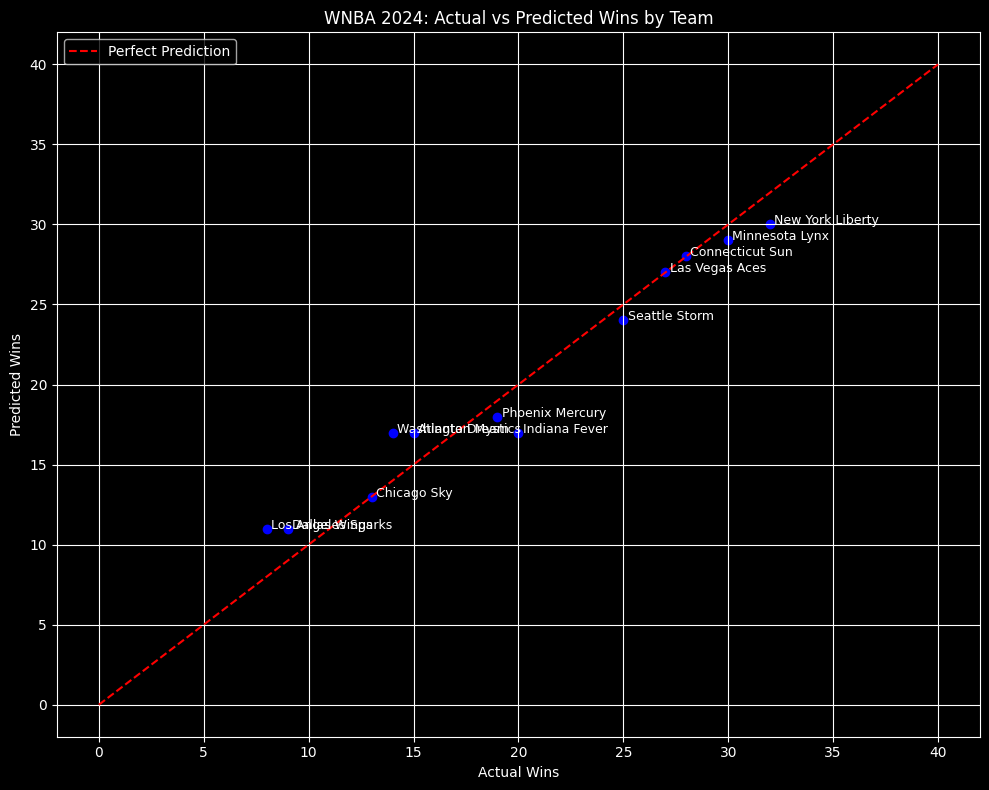

In [19]:
#Plot Predicted vs Actual Wins
plt.figure(figsize=(10, 8))
plt.scatter(df_test['W'], df_test['Predicted Wins'], color='blue')

# Add diagonal reference line
plt.plot([0, 40], [0, 40], 'r--', label='Perfect Prediction')

# Add team labels to each point
for i, row in df_test.iterrows():
    plt.text(row['W'] + 0.2, row['Predicted Wins'], row['TEAM_NAME'], fontsize=9)

plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('WNBA 2024: Actual vs Predicted Wins by Team')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
#Let's Scrape the WNBA standings for 2025
headers = {
    'Accept': '*/*',
    'Accept-Language': 'en-US,en;q=0.9',
    'Connection': 'keep-alive',
    'Origin': 'https://www.wnba.com',
    'Referer': 'https://www.wnba.com/',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
    'Host': 'stats.wnba.com',
    'x-wnba-stats-origin': 'stats',
    'x-wnba-stats-token': 'true'
}

def json_extract():
    years = ['2025']
    # Went to 2018 because that's when ORTG boost and pace increased
    all_data = []  # List to store data from all years

    for year in years:
        url = F'https://stats.wnba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=10&Location=&MeasureType=Four+Factors&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={year}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='

        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                data = response.json()
                print(f"Successfully got data for {year}!")
                
                # Create DataFrame for current year
                df_year = pd.DataFrame(data['resultSets'][0]['rowSet'], 
                columns=data['resultSets'][0]['headers'])
                
                # Add year column
                df_year['Season'] = year
                
                # Append to list of DataFrames
                all_data.append(df_year)
            else:
                print(f"Failed to get data for {year}: Status code {response.status_code}")
                
        except Exception as e:
            print(f"Error occurred for {year}: {e}")

    # Combine all DataFrames
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

# Execute function and store result
df_2025 = json_extract()
df_2025.head()

Successfully got data for 2025!


,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,MIN_RANK,EFG_PCT_RANK,FTA_RATE_RANK,TM_TOV_PCT_RANK,OREB_PCT_RANK,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,Season
0,1611661330,Atlanta Dream,27,16,11,0.593,1085.0,0.505,0.301,0.164,...,3,5,5,3,4,7,3,13,1,2025
1,1611661329,Chicago Sky,26,7,19,0.269,1040.0,0.471,0.264,0.218,...,10,11,11,13,2,12,9,12,8,2025
2,1611661323,Connecticut Sun,25,4,21,0.160,1000.0,0.451,0.282,0.184,...,13,13,8,9,9,13,12,6,13,2025
3,1611661321,Dallas Wings,28,8,20,0.286,1125.0,0.469,0.269,0.180,...,1,12,9,8,1,10,13,10,6,2025
4,1611661331,Golden State Valkyries,26,13,13,0.500,1045.0,0.474,0.293,0.196,...,8,10,6,12,3,2,8,11,3,2025


In [21]:
#Let's apply our model to the 2025 data
#First we need the deviations
def calc_dev():
    df_2025['Shooting Dev'] = df_2025['EFG_PCT']-df_2025['OPP_EFG_PCT']
    df_2025['Rebounding Dev'] = df_2025['OREB_PCT']-df_2025['OPP_OREB_PCT']
    df_2025['Turnover Dev'] = df_2025['TM_TOV_PCT']-df_2025['OPP_TOV_PCT']
    df_2025['Free Throw Dev'] = df_2025['FTA_RATE']-df_2025['OPP_FTA_RATE']
    return df_2025
calc_dev()
df_2025.head(5)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,OREB_PCT_RANK,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,Season,Shooting Dev,Rebounding Dev,Turnover Dev,Free Throw Dev
0,1611661330,Atlanta Dream,27,16,11,0.593,1085.0,0.505,0.301,0.164,...,4,7,3,13,1,2025,0.018,0.046,0.006,0.054
1,1611661329,Chicago Sky,26,7,19,0.269,1040.0,0.471,0.264,0.218,...,2,12,9,12,8,2025,-0.053,0.046,0.058,-0.033
2,1611661323,Connecticut Sun,25,4,21,0.160,1000.0,0.451,0.282,0.184,...,9,13,12,6,13,2025,-0.083,-0.055,0.001,-0.063
3,1611661321,Dallas Wings,28,8,20,0.286,1125.0,0.469,0.269,0.180,...,1,10,13,10,6,2025,-0.046,0.059,0.011,-0.087
4,1611661331,Golden State Valkyries,26,13,13,0.500,1045.0,0.474,0.293,0.196,...,3,2,8,11,3,2025,0.000,0.049,0.031,-0.003


In [25]:
#Let's apply our model to the 2025 data
# 1. Select the same features used in training
X_2025 = df_2025[features]  # e.g., ['EFG_diff', 'TOV_diff', 'ORB_diff', 'FT_diff']

# 2. Predict win percentage using the trained model
predicted_win_pct = lr.predict(X_2025)

# 3. Multiply by number of games and round to whole number wins
df_2025['Predicted Wins'] = (predicted_win_pct * df_2025['GP']).round().astype(int)
df_2025['Predicted Szn Wins'] = (predicted_win_pct * 40).round().astype(int)


In [41]:
df_2025["Win Difference"] = df_2025['Predicted Wins'] - df_2025["W"]
df_2025.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,Season,Shooting Dev,Rebounding Dev,Turnover Dev,Free Throw Dev,Predicted Wins,Win Difference,Predicted Szn Wins
0,1611661330,Atlanta Dream,27,16,11,0.593,1085.0,0.505,0.301,0.164,...,13,1,2025,0.018,0.046,0.006,0.054,17,1,26
1,1611661329,Chicago Sky,26,7,19,0.269,1040.0,0.471,0.264,0.218,...,12,8,2025,-0.053,0.046,0.058,-0.033,4,-3,6
2,1611661323,Connecticut Sun,25,4,21,0.160,1000.0,0.451,0.282,0.184,...,6,13,2025,-0.083,-0.055,0.001,-0.063,1,-3,2
3,1611661321,Dallas Wings,28,8,20,0.286,1125.0,0.469,0.269,0.180,...,10,6,2025,-0.046,0.059,0.011,-0.087,8,0,11
4,1611661331,Golden State Valkyries,26,13,13,0.500,1045.0,0.474,0.293,0.196,...,11,3,2025,0.000,0.049,0.031,-0.003,12,-1,18


In [42]:
#Let's clean up the DataFrame to only include relevant columns and reorder them
df_2025_cleaned = df_2025.copy()
df_2025_cleaned.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,Season,Shooting Dev,Rebounding Dev,Turnover Dev,Free Throw Dev,Predicted Wins,Win Difference,Predicted Szn Wins
0,1611661330,Atlanta Dream,27,16,11,0.593,1085.0,0.505,0.301,0.164,...,13,1,2025,0.018,0.046,0.006,0.054,17,1,26
1,1611661329,Chicago Sky,26,7,19,0.269,1040.0,0.471,0.264,0.218,...,12,8,2025,-0.053,0.046,0.058,-0.033,4,-3,6
2,1611661323,Connecticut Sun,25,4,21,0.160,1000.0,0.451,0.282,0.184,...,6,13,2025,-0.083,-0.055,0.001,-0.063,1,-3,2
3,1611661321,Dallas Wings,28,8,20,0.286,1125.0,0.469,0.269,0.180,...,10,6,2025,-0.046,0.059,0.011,-0.087,8,0,11
4,1611661331,Golden State Valkyries,26,13,13,0.500,1045.0,0.474,0.293,0.196,...,11,3,2025,0.000,0.049,0.031,-0.003,12,-1,18


In [43]:
# Drop columns: 'TEAM_ID', 'MIN' and 13 other columns
df_2025_cleaned = df_2025_cleaned.drop(columns=['TEAM_ID', 'MIN', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'EFG_PCT_RANK', 'FTA_RATE_RANK', 'TM_TOV_PCT_RANK', 'OREB_PCT_RANK', 'OPP_EFG_PCT_RANK', 'OPP_FTA_RATE_RANK', 'OPP_TOV_PCT_RANK', 'OPP_OREB_PCT_RANK','OPP_TOV_PCT_RANK'])

In [44]:
df_2025_cleaned

,TEAM_NAME,GP,W,L,W_PCT,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,...,OPP_TOV_PCT,OPP_OREB_PCT,Season,Shooting Dev,Rebounding Dev,Turnover Dev,Free Throw Dev,Predicted Wins,Win Difference,Predicted Szn Wins
0,Atlanta Dream,27,16,11,0.593,0.505,0.301,0.164,0.315,0.487,...,0.158,0.269,2025,0.018,0.046,0.006,0.054,17,1,26
1,Chicago Sky,26,7,19,0.269,0.471,0.264,0.218,0.352,0.524,...,0.160,0.306,2025,-0.053,0.046,0.058,-0.033,4,-3,6
2,Connecticut Sun,25,4,21,0.160,0.451,0.282,0.184,0.289,0.534,...,0.183,0.344,2025,-0.083,-0.055,0.001,-0.063,1,-3,2
3,Dallas Wings,28,8,20,0.286,0.469,0.269,0.180,0.359,0.515,...,0.169,0.300,2025,-0.046,0.059,0.011,-0.087,8,0,11
4,Golden State Valkyries,26,13,13,0.500,0.474,0.293,0.196,0.326,0.474,...,0.165,0.277,2025,0.000,0.049,0.031,-0.003,12,-1,18
5,Indiana Fever,27,15,12,0.556,0.517,0.285,0.178,0.311,0.486,...,0.184,0.300,2025,0.031,0.011,-0.006,-0.031,17,2,25
6,Las Vegas Aces,27,14,13,0.519,0.480,0.303,0.171,0.274,0.492,...,0.173,0.314,2025,-0.012,-0.040,-0.002,0.043,12,-2,18
7,Los Angeles Sparks,26,11,15,0.423,0.521,0.337,0.195,0.301,0.517,...,0.169,0.305,2025,0.004,-0.004,0.026,0.075,13,2,20
8,Minnesota Lynx,28,23,5,0.821,0.534,0.246,0.164,0.292,0.470,...,0.199,0.315,2025,0.064,-0.023,-0.035,0.004,23,0,34
9,New York Liberty,26,17,9,0.654,0.530,0.301,0.167,0.246,0.483,...,0.185,0.318,2025,0.047,-0.072,-0.018,0.064,19,2,29


In [45]:
#Reorder the columns
df_2025_cleaned = df_2025_cleaned.reindex(columns=['TEAM_NAME','GP','W','L','W_PCT','Predicted Wins','Win Difference','Predicted Szn Wins','EFG_PCT','OPP_EFG_PCT','OREB_PCT','OPP_OREB_PCT','TM_TOV_PCT','OPP_TOV_PCT','FTA_RATE','OPP_FTA_RATE','Shooting Dev','Rebounding Dev','Turnover Dev','Free Throw Dev'])
df_2025_cleaned

,TEAM_NAME,GP,W,L,W_PCT,Predicted Wins,Win Difference,Predicted Szn Wins,EFG_PCT,OPP_EFG_PCT,OREB_PCT,OPP_OREB_PCT,TM_TOV_PCT,OPP_TOV_PCT,FTA_RATE,OPP_FTA_RATE,Shooting Dev,Rebounding Dev,Turnover Dev,Free Throw Dev
0,Atlanta Dream,27,16,11,0.593,17,1,26,0.505,0.487,0.315,0.269,0.164,0.158,0.301,0.247,0.018,0.046,0.006,0.054
1,Chicago Sky,26,7,19,0.269,4,-3,6,0.471,0.524,0.352,0.306,0.218,0.160,0.264,0.297,-0.053,0.046,0.058,-0.033
2,Connecticut Sun,25,4,21,0.160,1,-3,2,0.451,0.534,0.289,0.344,0.184,0.183,0.282,0.345,-0.083,-0.055,0.001,-0.063
3,Dallas Wings,28,8,20,0.286,8,0,11,0.469,0.515,0.359,0.300,0.180,0.169,0.269,0.356,-0.046,0.059,0.011,-0.087
4,Golden State Valkyries,26,13,13,0.500,12,-1,18,0.474,0.474,0.326,0.277,0.196,0.165,0.293,0.296,0.000,0.049,0.031,-0.003
5,Indiana Fever,27,15,12,0.556,17,2,25,0.517,0.486,0.311,0.300,0.178,0.184,0.285,0.316,0.031,0.011,-0.006,-0.031
6,Las Vegas Aces,27,14,13,0.519,12,-2,18,0.480,0.492,0.274,0.314,0.171,0.173,0.303,0.260,-0.012,-0.040,-0.002,0.043
7,Los Angeles Sparks,26,11,15,0.423,13,2,20,0.521,0.517,0.301,0.305,0.195,0.169,0.337,0.262,0.004,-0.004,0.026,0.075
8,Minnesota Lynx,28,23,5,0.821,23,0,34,0.534,0.470,0.292,0.315,0.164,0.199,0.246,0.242,0.064,-0.023,-0.035,0.004
9,New York Liberty,26,17,9,0.654,19,2,29,0.530,0.483,0.246,0.318,0.167,0.185,0.301,0.237,0.047,-0.072,-0.018,0.064


In [47]:
#Save data to csv
df_2025_cleaned.to_csv('wnba_2025_predictions.csv', index=False)